## Import libraries

In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Attention, Dropout
from tensorflow.keras.layers import Concatenate, Flatten
from tensorflow.keras.layers import Conv1D, Input, Dense
from tensorflow.keras.layers import Embedding, Activation
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

## Prepare data for model training

In [2]:
train_df = pd.read_csv("../input/tabular-playground-series-jun-2021/train.csv")
train_df['target'] = train_df['target'].apply(lambda x: int(x.replace("Class_","")))
train_df['target'] = train_df['target'].apply(lambda x: 0 if x==9 else x)
train_df.set_index("id", inplace=True)
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,6,1,0,0,0,0,7,0,...,0,0,0,0,0,0,2,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,6
2,0,0,0,0,0,1,0,3,0,0,...,0,0,0,0,1,0,0,0,0,2
3,0,0,7,0,1,5,2,2,0,1,...,0,4,0,2,2,0,4,3,0,8
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [3]:
test_df = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
test_df.set_index("id", inplace=True)
test_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
id,,,,,,,,,,,,,,,,,,,,,
200000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200001,1,2,0,0,0,0,0,0,0,0,...,3,1,3,0,0,0,0,3,0,0
200002,0,1,7,1,0,0,0,0,6,0,...,3,0,0,0,0,3,0,2,0,0
200003,0,0,0,4,3,1,0,0,0,0,...,0,0,0,1,0,0,0,4,0,0
200004,0,0,5,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,1,0


In [4]:
Xtrain = train_df.loc[:, train_df.columns != 'target'].copy()
Ytrain = train_df['target'].copy()
Ytrain_oh = pd.get_dummies(train_df['target']).copy()
Xtest = test_df.copy()

print("Xtrain: {} \nYtrain: {} \nYtrain_oh: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, 
                                                                   Ytrain_oh.shape, Xtest.shape))

del train_df
del test_df
gc.collect()

Xtrain: (200000, 75) 
Ytrain: (200000,) 
Ytrain_oh: (200000, 9) 
Xtest: (100000, 75)


62

## Define TPU config

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

Running on TPU: grpc://10.0.0.2:8470


In [6]:
mini_batch_size = strategy.num_replicas_in_sync * 32
print(f'batch size: {mini_batch_size}')

batch size: 256


## Build the model

In [7]:
def conv_model(n_features):
    
    x_input = Input(shape=(n_features,))
    
    embed = Embedding(input_dim=384, output_dim=8, 
                      embeddings_initializer='lecun_normal')(x_input)
    embed = LayerNormalization(epsilon=1e-5)(embed)
    
    x1 = Conv1D(filters=12, kernel_size=5, 
                strides=2, padding='same', 
                kernel_regularizer=l2(0.0003), 
                kernel_initializer='lecun_normal')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = Activation('relu')(x1)
    x1 = SpatialDropout1D(rate=0.2)(x1)
    
    x2 = Conv1D(filters=12, kernel_size=5, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0003), 
                kernel_initializer='lecun_normal')(embed)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = Activation('relu')(x2)
    x2 = SpatialDropout1D(rate=0.2)(x2)
    
    x1 = Attention()([x1, x2])
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x1 = Flatten()(x1)
    x = Dropout(rate=0.2)(x1)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.25)(x)
    
    x_output = Dense(units=9, activation='softmax', 
                     kernel_initializer='lecun_normal')(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='CONV_Model')
    return model

In [8]:
def conv_lstm_model(n_features):
    
    x_input = Input(shape=(n_features,))
    
    embed = Embedding(input_dim=384, output_dim=8, 
                      embeddings_initializer='lecun_normal')(x_input)
    embed = LayerNormalization(epsilon=1e-5)(embed)
    
    x1 = Conv1D(filters=16, kernel_size=5, 
                strides=2, padding='same', 
                kernel_regularizer=l2(0.0003), 
                kernel_initializer='lecun_normal')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = Activation('relu')(x1)
    x1 = SpatialDropout1D(rate=0.2)(x1)
    
    x2 = Bidirectional(LSTM(units=16, activation='tanh',
                            return_sequences=True, dropout=0.15,
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer='lecun_normal'), 
                      merge_mode='ave')(embed)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    
    x1 = Attention()([x1, x2])
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x1 = Flatten()(x1)
    x = Dropout(rate=0.2)(x1)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.25)(x)
    
    x_output = Dense(units=9, activation='softmax', 
                     kernel_initializer='lecun_normal')(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='CONV_LSTM_Model')
    return model

In [9]:
def lstm_gru_model(n_features):
    
    x_input = Input(shape=(n_features,))
    
    embed = Embedding(input_dim=384, output_dim=8, 
                      embeddings_initializer='lecun_normal')(x_input)
    embed = LayerNormalization(epsilon=1e-5)(embed)
    
    x1 = Bidirectional(LSTM(units=16, activation='tanh',
                            return_sequences=True, dropout=0.15,
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer='lecun_normal'), 
                      merge_mode='ave')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x2 = Bidirectional(GRU(units=16, activation='tanh',
                           return_sequences=True, dropout=0.15,
                           kernel_regularizer=l2(0.0001),
                           kernel_initializer='lecun_normal'),
                      merge_mode='ave')(embed)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    
    x1 = Attention()([x1, x2])
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x1 = Flatten()(x1)
    x = Dropout(rate=0.2)(x1)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
                kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.15)(x)

    x_output = Dense(units=9, activation='softmax', 
                     kernel_initializer='lecun_normal')(x)
    
    model = Model(inputs=x_input, outputs=x_output, 
                  name='LSTM_GRU_Model')
    return model

In [10]:
def fit_model(model, checkpoint, verbose, init_lr=8e-3):
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adamax(lr=init_lr))
    
    early = EarlyStopping(monitor="val_loss", mode="min", 
                          restore_best_weights=True, 
                          patience=9, verbose=verbose)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.25, 
                                  min_lr=1e-6, patience=4, 
                                  verbose=verbose, mode='min')

    chk_point = ModelCheckpoint(checkpoint, monitor='val_loss', 
                                verbose=verbose, save_best_only=True, 
                                mode='min', save_weights_only=True)

    history = model.fit(
        train_x, train_y_oh, 
        batch_size=mini_batch_size,
        epochs=150, 
        verbose=verbose, 
        callbacks=[reduce_lr, early, chk_point], 
        validation_data=(val_x, val_y_oh)
    )
    
    return model

In [11]:
model1 = conv_model(Xtrain.shape[1])
model1.summary()

Model: "CONV_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 8)        3072        input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 75, 8)        16          embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 38, 12)       492         layer_normalization[0][0]        
_________________________________________________________________________________________

In [12]:
model2 = conv_lstm_model(Xtrain.shape[1])
model2.summary()

Model: "CONV_LSTM_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 8)        3072        input_2[0][0]                    
__________________________________________________________________________________________________
layer_normalization_4 (LayerNor (None, 75, 8)        16          embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 38, 16)       656         layer_normalization_4[0][0]      
____________________________________________________________________________________

In [13]:
model3 = lstm_gru_model(Xtrain.shape[1])
model3.summary()

Model: "LSTM_GRU_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 8)        3072        input_3[0][0]                    
__________________________________________________________________________________________________
layer_normalization_8 (LayerNor (None, 75, 8)        16          embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 75, 16)       3200        layer_normalization_8[0][0]      
_____________________________________________________________________________________

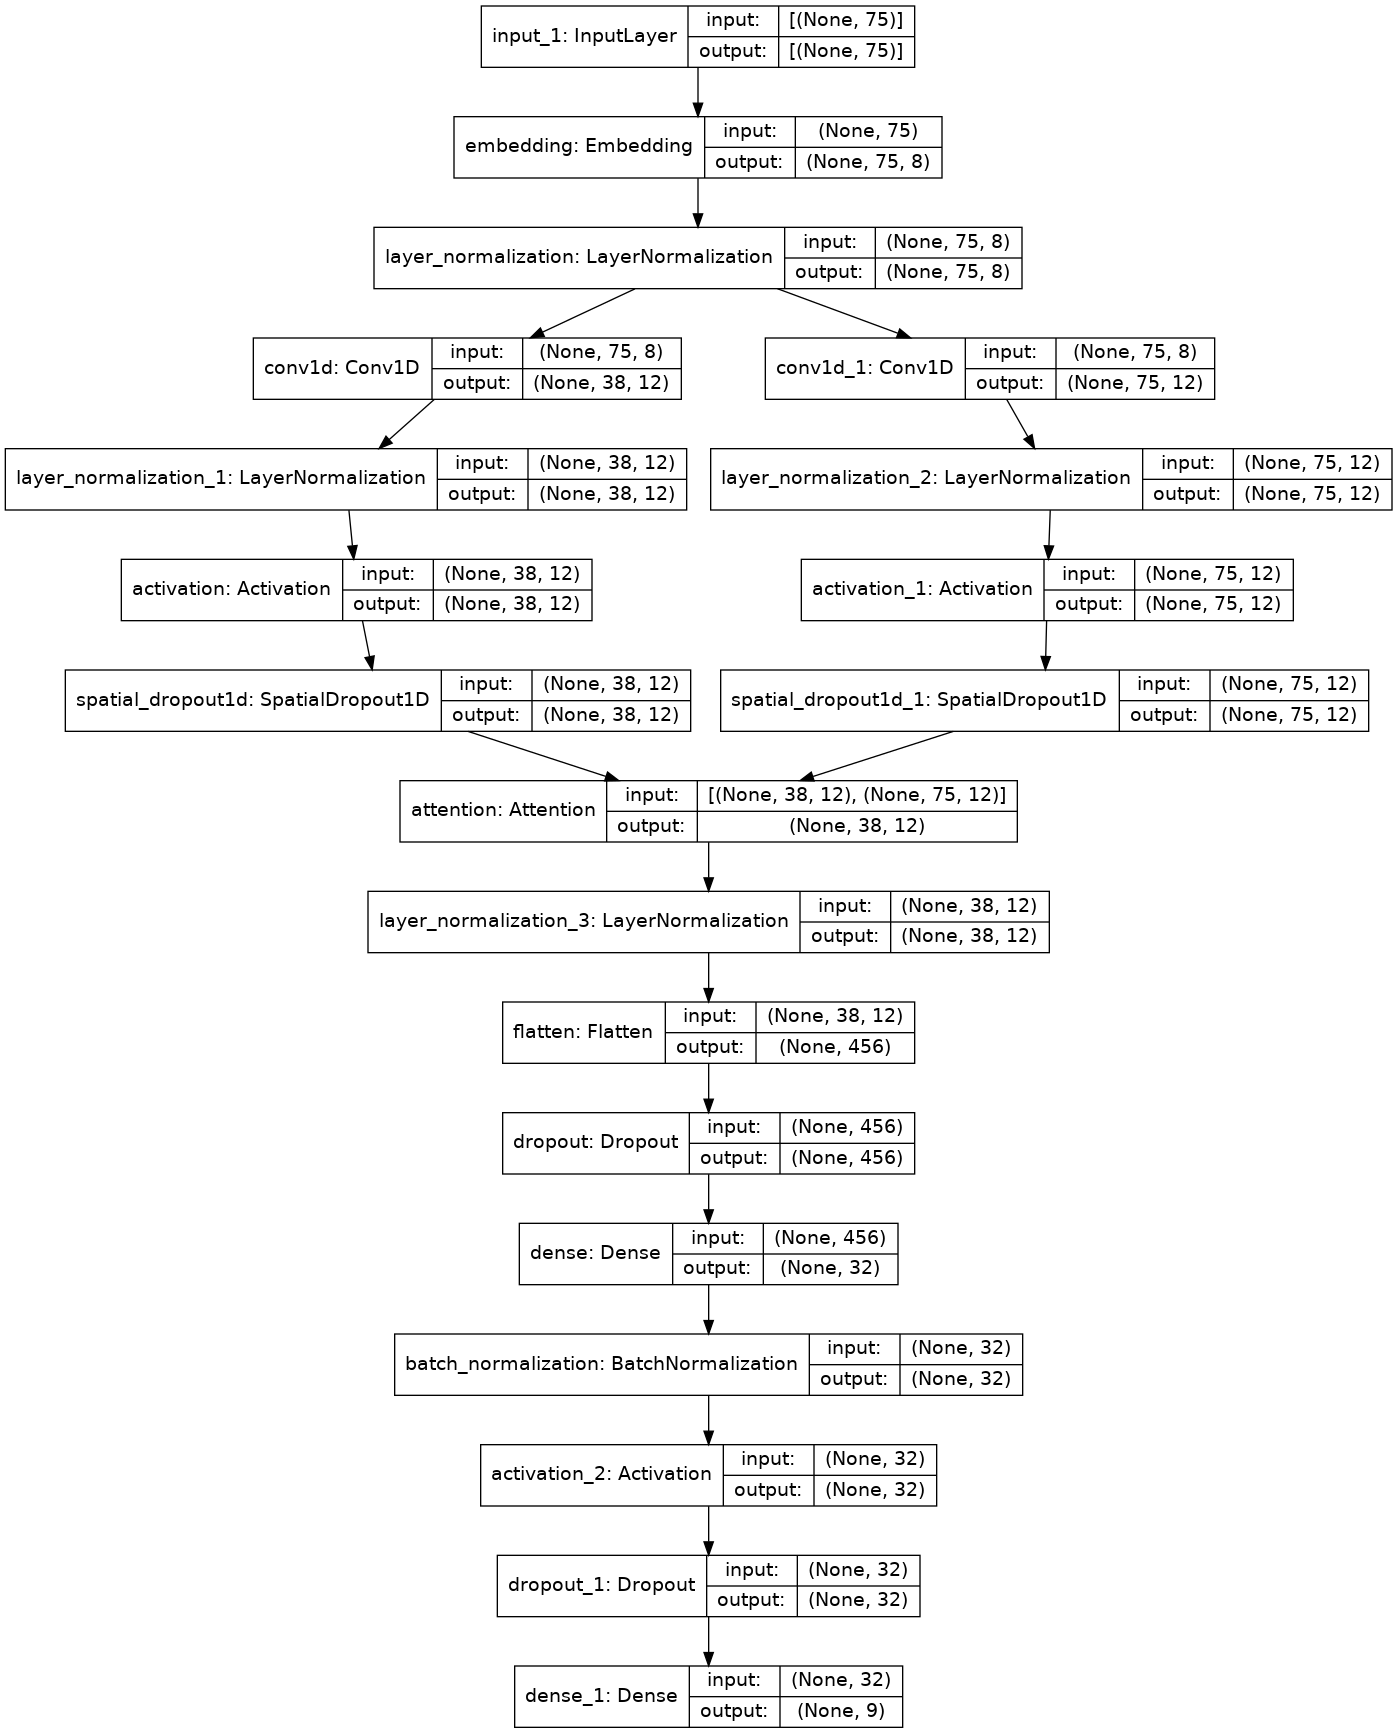

In [14]:
plot_model(
    model1, to_file='./CONV_Model.png', 
    show_shapes=True, show_layer_names=True
)

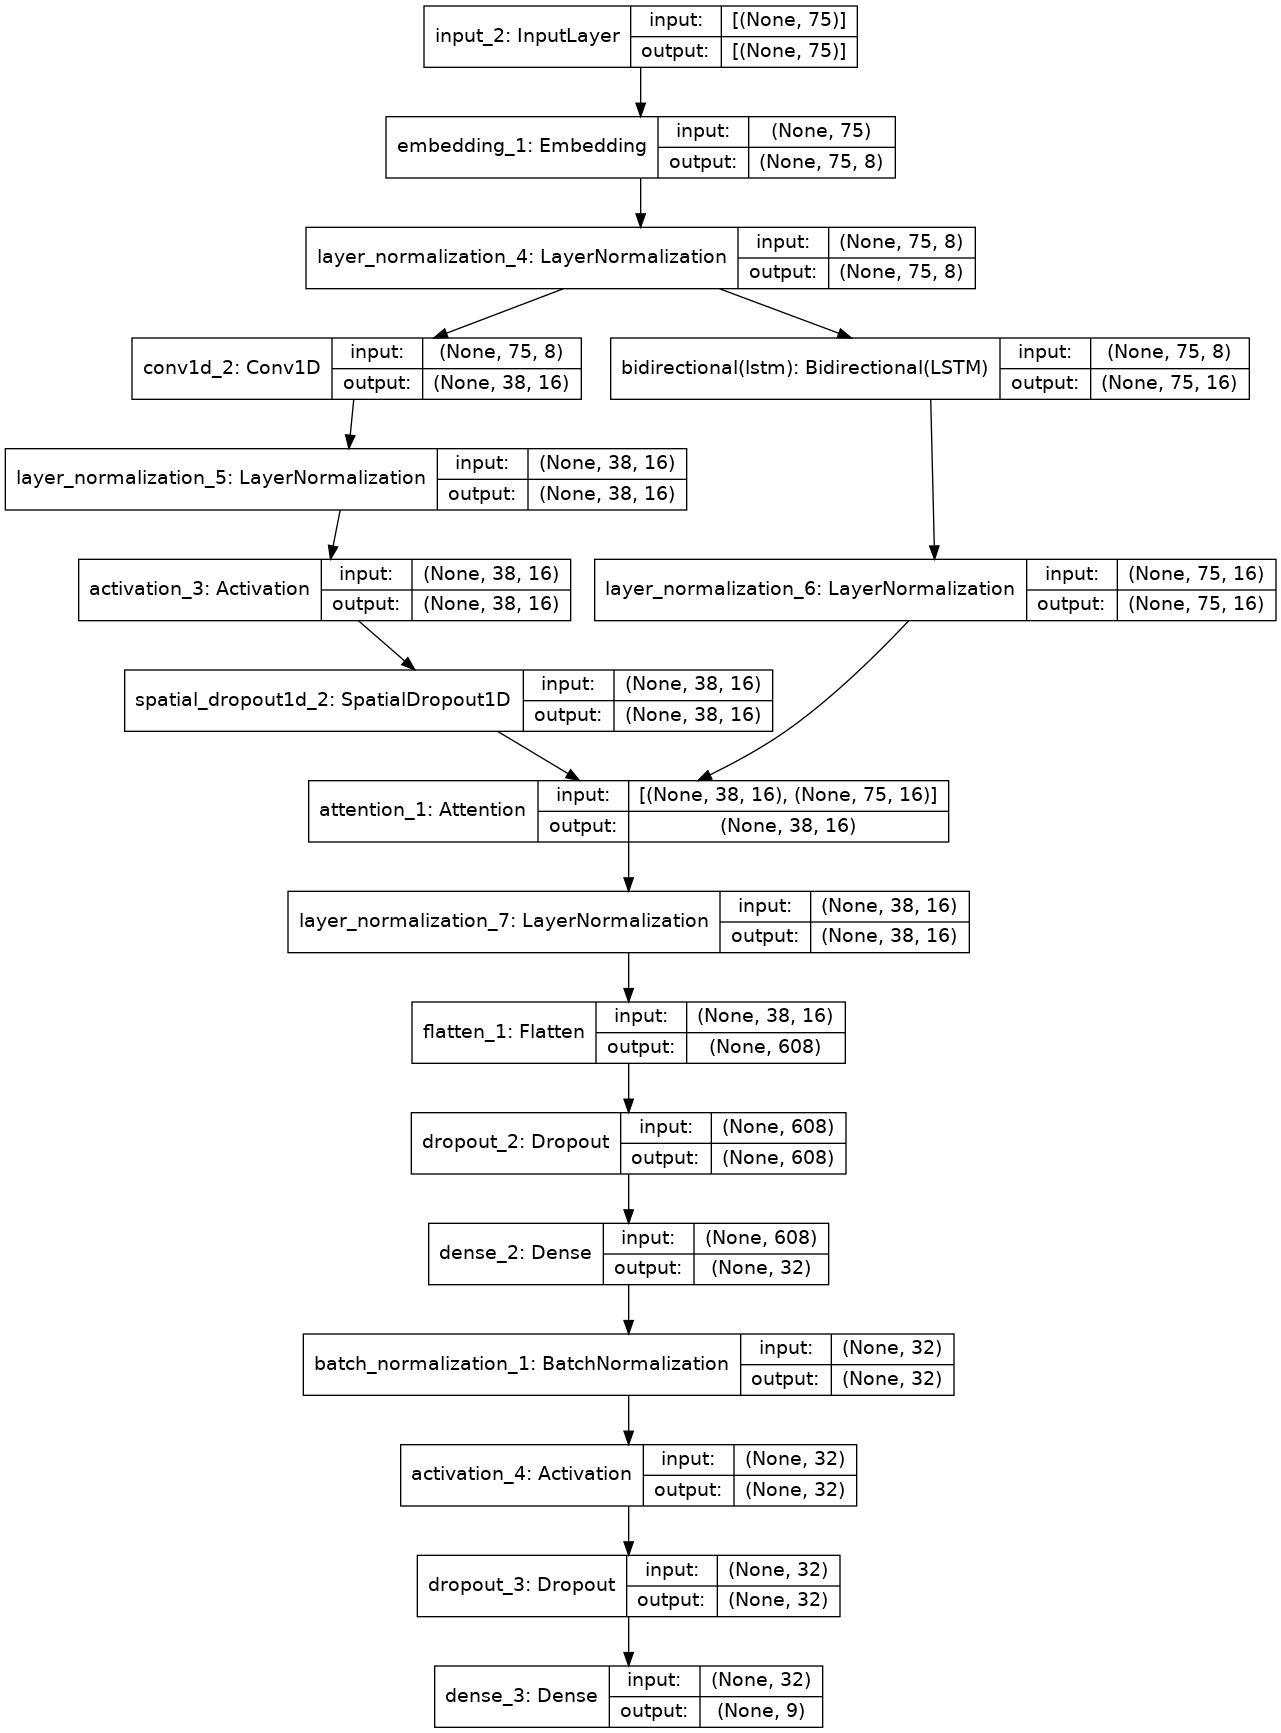

In [15]:
plot_model(
    model2, to_file='./CONV_LSTM_Model.png', 
    show_shapes=True, show_layer_names=True
)

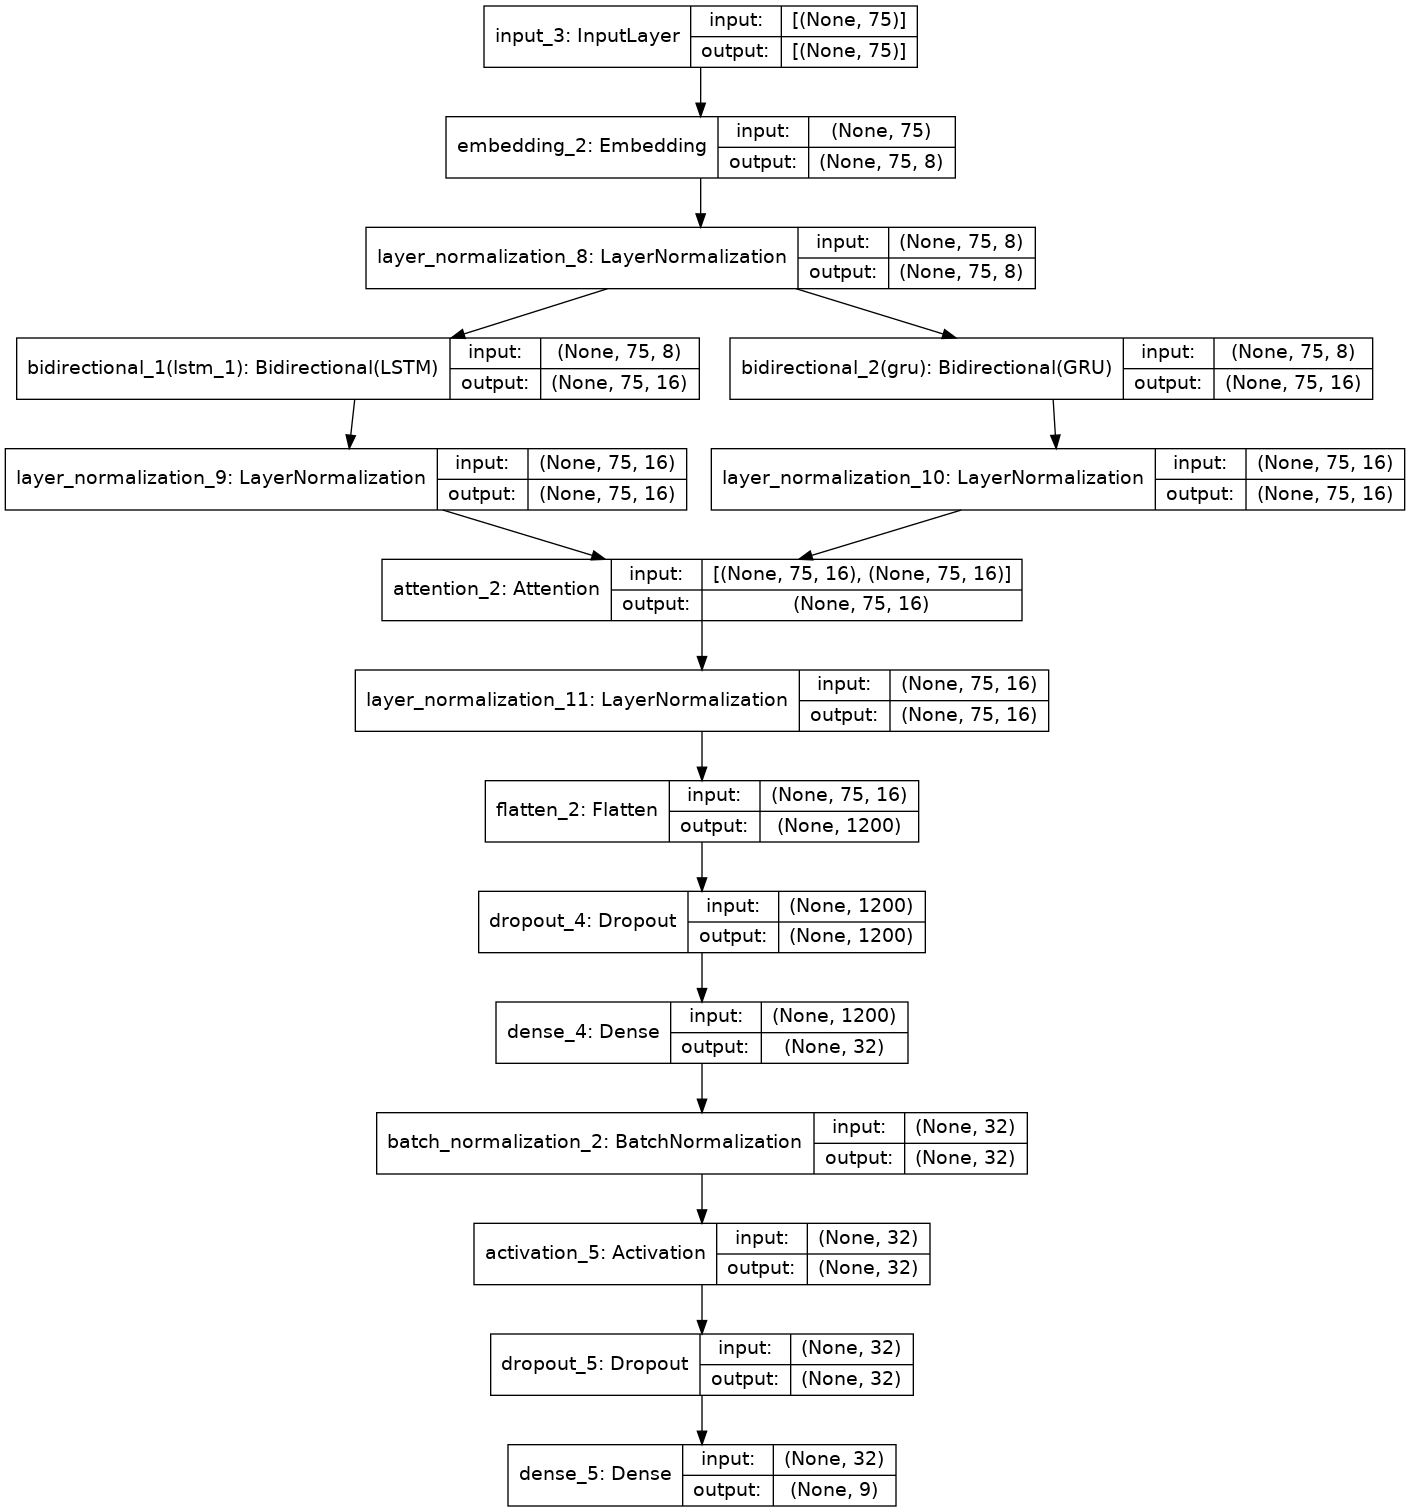

In [16]:
plot_model(
    model3, to_file='./LSTM_GRU_Model.png', 
    show_shapes=True, show_layer_names=True
)

In [17]:
FOLD = 20
NUM_SEED = 1
VERBOSE = 0

np.random.seed(29)
seeds = np.random.randint(0, 100, size=NUM_SEED)

counter = 0
#oof_score1 = 0
oof_score2 = 0
oof_score3 = 0

#y_pred_meta_dnn1 = np.zeros((Xtrain.shape[0], 9))
y_pred_meta_dnn2 = np.zeros((Xtrain.shape[0], 9))
y_pred_meta_dnn3 = np.zeros((Xtrain.shape[0], 9))

#y_pred_final_dnn1 = np.zeros((Xtest.shape[0], 9))
y_pred_final_dnn2 = np.zeros((Xtest.shape[0], 9))
y_pred_final_dnn3 = np.zeros((Xtest.shape[0], 9))

In [18]:
with strategy.scope():
    
    for sidx, seed in enumerate(seeds):
        #seed_score1 = 0
        seed_score2 = 0
        seed_score3 = 0

        kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

        for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
            counter += 1

            train_x, train_y, train_y_oh = Xtrain.iloc[train], Ytrain.iloc[train], Ytrain_oh.iloc[train]
            val_x, val_y, val_y_oh = Xtrain.iloc[val], Ytrain.iloc[val], Ytrain_oh.iloc[val]
            
            #=========================================================
            #                        CONV Model
            #=========================================================
            '''
            tf.random.set_seed(seed+idx+1)
            
            model = conv_model(Xtrain.shape[1])
            
            model = fit_model(model, checkpoint=f"./CONV_Model_{counter}C.h5", 
                              verbose=VERBOSE)

            model.load_weights(f'./CONV_Model_{counter}C.h5')

            y_pred = model.predict(val_x)
            y_pred_meta_dnn1[val] += y_pred
            y_pred_final_dnn1 += model.predict(Xtest)

            score = log_loss(val_y_oh, y_pred)
            oof_score1 += score
            seed_score1 += score
            print("CONV_Model | Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
            '''
            #=========================================================
            #                      CONV-LSTM Model
            #=========================================================
            
            tf.random.set_seed(seed+idx+2)
            
            model = conv_lstm_model(Xtrain.shape[1])
            
            model = fit_model(model, checkpoint=f"./CONV_LSTM_Model_{counter}C.h5", 
                              verbose=VERBOSE)

            model.load_weights(f'./CONV_LSTM_Model_{counter}C.h5')

            y_pred = model.predict(val_x)
            y_pred_meta_dnn2[val] += y_pred
            y_pred_final_dnn2 += model.predict(Xtest)

            score = log_loss(val_y_oh, y_pred)
            oof_score2 += score
            seed_score2 += score
            print("CONV_LSTM_Model | Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
            
            #=========================================================
            #                       LSTM-GRU Model
            #=========================================================
            
            tf.random.set_seed(seed+idx+3)
            
            model = lstm_gru_model(Xtrain.shape[1])
            
            model = fit_model(model, checkpoint=f"./LSTM_GRU_Model_{counter}C.h5", 
                              verbose=VERBOSE)

            model.load_weights(f'./LSTM_GRU_Model_{counter}C.h5')

            y_pred = model.predict(val_x)
            y_pred_meta_dnn3[val] += y_pred
            y_pred_final_dnn3 += model.predict(Xtest)

            score = log_loss(val_y_oh, y_pred)
            oof_score3 += score
            seed_score3 += score
            print("LSTM_GRU_Model | Seed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
            

        #print("\nCONV_Model | Seed: {} | Aggregate OOF Score: {}".format(seed, (seed_score1 / FOLD)))
        print("CONV_LSTM_Model | Seed: {} | Aggregate OOF Score: {}".format(seed, (seed_score2 / FOLD)))
        print("LSTM_GRU_Model | Seed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score3 / FOLD)))

CONV_LSTM_Model | Seed-85 | Fold-0 | OOF Score: 1.74391742315609
LSTM_GRU_Model | Seed-85 | Fold-0 | OOF Score: 1.7439930966910906

CONV_LSTM_Model | Seed-85 | Fold-1 | OOF Score: 1.7504578103449195
LSTM_GRU_Model | Seed-85 | Fold-1 | OOF Score: 1.7490430994863622

CONV_LSTM_Model | Seed-85 | Fold-2 | OOF Score: 1.740030369755812
LSTM_GRU_Model | Seed-85 | Fold-2 | OOF Score: 1.7388483201941476

CONV_LSTM_Model | Seed-85 | Fold-3 | OOF Score: 1.7455804197251796
LSTM_GRU_Model | Seed-85 | Fold-3 | OOF Score: 1.7462637139618398

CONV_LSTM_Model | Seed-85 | Fold-4 | OOF Score: 1.7433831960631534
LSTM_GRU_Model | Seed-85 | Fold-4 | OOF Score: 1.7431463991817087

CONV_LSTM_Model | Seed-85 | Fold-5 | OOF Score: 1.7332363773267716
LSTM_GRU_Model | Seed-85 | Fold-5 | OOF Score: 1.735694930783473

CONV_LSTM_Model | Seed-85 | Fold-6 | OOF Score: 1.7360670101411642
LSTM_GRU_Model | Seed-85 | Fold-6 | OOF Score: 1.7345317174317316

CONV_LSTM_Model | Seed-85 | Fold-7 | OOF Score: 1.7398062672323547

In [19]:
#y_pred_meta_dnn1 = y_pred_meta_dnn1 / float(NUM_SEED)
y_pred_meta_dnn2 = y_pred_meta_dnn2 / float(NUM_SEED)
y_pred_meta_dnn3 = y_pred_meta_dnn3 / float(NUM_SEED)

#y_pred_final_dnn1 = y_pred_final_dnn1 / float(counter)
y_pred_final_dnn2 = y_pred_final_dnn2 / float(counter)
y_pred_final_dnn3 = y_pred_final_dnn3 / float(counter)

#oof_score1 /= float(counter)
oof_score2 /= float(counter)
oof_score3 /= float(counter)
oof_score = (oof_score2 + oof_score3) / 2.0
print("Aggregate OOF Score: {}".format(oof_score))

Aggregate OOF Score: 1.742773990122583


In [20]:
np.savez_compressed('./Mojito_Meta_Features.npz',
                    #y_pred_meta_dnn1=y_pred_meta_dnn1, 
                    y_pred_meta_dnn2=y_pred_meta_dnn2, 
                    y_pred_meta_dnn3=y_pred_meta_dnn3, 
                    #oof_score1=oof_score1,
                    oof_score2=oof_score2,
                    oof_score3=oof_score3,
                    #y_pred_final_dnn1=y_pred_final_dnn1,
                    y_pred_final_dnn2=y_pred_final_dnn2,
                    y_pred_final_dnn3=y_pred_final_dnn3)

## Create submission file

In [21]:
y_pred_final_dnn = (y_pred_final_dnn2 + y_pred_final_dnn3) / 2.0

test_df = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submit_df = pd.DataFrame()
submit_df['id'] = test_df['id']
submit_df['Class_1'] = y_pred_final_dnn[:,1]
submit_df['Class_2'] = y_pred_final_dnn[:,2]
submit_df['Class_3'] = y_pred_final_dnn[:,3]
submit_df['Class_4'] = y_pred_final_dnn[:,4]
submit_df['Class_5'] = y_pred_final_dnn[:,5]
submit_df['Class_6'] = y_pred_final_dnn[:,6]
submit_df['Class_7'] = y_pred_final_dnn[:,7]
submit_df['Class_8'] = y_pred_final_dnn[:,8]
submit_df['Class_9'] = y_pred_final_dnn[:,0]
submit_df.to_csv("./Mojito_Submission.csv", index=False)
submit_df.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.071033,0.438941,0.158561,0.025458,0.012908,0.124603,0.018602,0.038663,0.111232
1,200001,0.040827,0.071274,0.051317,0.020596,0.013832,0.278363,0.086108,0.310258,0.127426
2,200002,0.016882,0.025550,0.018008,0.011564,0.006188,0.746435,0.027281,0.104062,0.044030
3,200003,0.046643,0.130827,0.091716,0.030838,0.018633,0.227974,0.077034,0.216452,0.159882
4,200004,0.042815,0.115112,0.082299,0.025165,0.014824,0.263212,0.073091,0.237711,0.145770
